In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from statsmodels.tsa.seasonal import seasonal_decompose


In [27]:
df_week_2020_23 = pd.read_csv('./data/VolumeDataset_2020_to_2023.csv')
df_daily_2021_23 = pd.read_csv('./data/data_dailly_2021_to_2023.csv').fillna(1.0)
df_monthly_2020_23 = pd.read_csv('./data/Month_clean_data.csv')
df_jan24_march24 = pd.read_excel('./data/data_jan24_March24.xlsx')
holidays_2020_23 = pd.read_csv('./data/holiday/holiday_2020.csv')
temp_2020_23 = pd.read_excel('./data/temperature/E1_Temperature_2021_23.xlsx')
from datetime import datetime
temp_delhi = pd.read_excel('./data/temperature/temp_n2_w3_s2/delhi_avg_tem_2020_23.xlsx')
# date = f'{temp_delhi.DayOfMonth}-{temp_delhi.Month}-{temp_delhi.Year}'
temp_delhi.Date = pd.to_datetime(temp_delhi[['Year', 'Month', 'Day']])

#  Made Date index column 
dates = df_week_2020_23.Year*100+df_week_2020_23.Week
df_week_2020_23['Date'] = pd.to_datetime(dates.astype(str) + '0', format='%Y%W%w')
# df_week_2020_23 = df_week_2020_23.set_index('Date')


for df in [df_week_2020_23, df_daily_2021_23, df_monthly_2020_23, df_jan24_march24, holidays_2020_23, temp_2020_23, temp_delhi]:
    display(df.head())

,Year,Week,A1,A2,E1,E2,N1,N2,N3,S1,S2,S3,W1,W2,W3,Cleared Volume,MCV,Date
0,2020,1,16911.93,33756.53,48253.47,51912.76,34120.12,48682.29,0.0,118862.33,8394.66,604.80,164894.79,70374.62,185102.58,781869.95,788121.16,2020-01-12
1,2020,2,16678.16,35520.72,68177.88,57986.37,42388.81,75084.86,0.0,148760.74,19815.62,650.20,257190.84,87611.24,304985.01,1114849.33,1129493.91,2020-01-19
2,2020,3,18848.19,23953.29,74396.13,39749.67,50518.35,90128.99,0.0,147718.97,22392.94,832.80,209441.27,90702.62,245815.56,1014497.72,1014497.72,2020-01-26
3,2020,4,13864.97,30214.57,66323.83,74711.48,44585.04,156190.36,0.0,162732.93,32756.68,750.60,181776.78,133732.89,159148.69,1056787.47,1056787.45,2020-02-02
4,2020,5,19588.03,27242.09,47763.37,83659.99,60050.33,154508.37,0.0,161117.18,26246.31,695.61,198066.16,132061.48,202806.64,1113804.41,1116246.21,2020-02-09


,Date,A1,A2,E1,E2,N1,N2,N3,S1,S2,S3,W1,W2,W3,Cleared Volume,MCV
0,01-01-2021,605.02,1726.52,5337.17,468.38,21401.74,24508.57,2400.0,60931.20,9387.48,540.80,3249.30,35848.57,6105.0,172509.52,172509.52
1,02-01-2021,196.68,1564.11,5396.61,216.00,26037.07,28410.74,1.0,57619.45,13055.97,483.60,2261.28,40121.49,6360.0,181722.80,181722.80
2,03-01-2021,236.21,1798.70,4397.97,411.94,26628.81,27061.66,1.0,51113.54,13176.51,697.16,2672.50,46251.51,2715.0,177161.26,177161.26
3,04-01-2021,127.75,2009.93,4667.26,372.25,28270.30,15970.95,1.0,53456.41,15575.81,755.58,2702.25,59565.27,2225.0,185698.56,185698.56
4,05-01-2021,165.57,1833.25,4636.69,292.70,22619.43,22700.87,1.0,64673.62,15496.28,677.17,2643.65,52591.89,1875.0,190205.91,190205.90


,Date,Month,A1,A2,E1,E2,N1,N2,N3,S1,S2,S3,W1,W2,W3,Cleared Volume,MCV
0,01-01-2020,1,66303.25,123445.11,257151.31,224360.28,171612.32,370086.50,0.0,578074.97,83359.90,2838.40,813303.68,382421.37,895051.84,3968004.47,3988900.24
1,01-02-2020,2,74862.97,104828.98,208028.44,434917.15,238676.95,476956.27,0.0,534379.41,142714.33,3102.46,568893.78,675279.49,757637.25,4220272.12,4222713.99
2,01-03-2020,3,37087.81,144506.05,620054.99,474525.58,326302.03,786295.16,0.0,199910.55,51569.67,2823.86,304063.81,447513.10,1247417.93,4642064.05,4657620.35
3,01-04-2020,4,42797.94,215447.04,386198.01,469504.46,523446.95,760255.22,0.0,54273.49,42244.35,1558.74,72899.64,507490.71,325247.66,3401358.28,3401358.27
4,01-05-2020,5,22426.57,147490.98,581634.38,940433.68,796148.85,477740.10,0.0,201199.84,61656.62,3883.37,403408.38,303068.90,844138.11,4783223.72,4783223.66


,Date,A1,A2,E1,E2,N1,N2,N3,S1,S2,S3,W1,W2,W3,Cleared Volume,MCV
0,01-01-2024,-,899.55,15741.70,-,17832.43,29158.40,21813.85,50466.03,5342.13,5786.68,2460.75,28108.17,-,177609.37,177609.37
1,02-01-2024,-,1019.36,15973.90,-,18210.17,24444.15,18831.70,43004.84,12290.27,3989.39,2149.93,25959.63,-,165873.11,165873.11
2,03-01-2024,57.50,999.18,15634.30,885.00,18755.38,27773.88,19108.40,27642.25,15558.40,4894.82,2117.77,23988.74,733.58,158148.80,158148.80
3,04-01-2024,-,865.37,16791.94,80.40,17988.00,27481.91,16006.11,46392.26,9209.09,3753.05,2397.77,34721.16,292.33,175979.09,175979.09
4,05-01-2024,20.00,992.83,17450.59,98.75,18589.64,30623.88,12671.31,50892.11,13869.65,3122.08,2382.37,29914.08,0.38,180627.34,180627.34


,date,holiday,holiday_type,day
0,01-01-2020,New Year's Day (R),Restricted,Wednesday
1,02-01-2020,Guru Gobind Singh's Birthday (R),Restricted,Thursday
2,13-01-2020,Lohri (R),Restricted,Monday
3,15-01-2020,Makar Sankranti/Pongal (R),Restricted,Wednesday
4,26-01-2020,Republic Day (G),Gazetted,Sunday


,Date,Kolkata
0,2020-01-01 00:00:00,17.9
1,2020-02-01 00:00:00,19.3
2,2020-03-01 00:00:00,16.7
3,2020-04-01 00:00:00,16.7
4,2020-05-01 00:00:00,16.5


,Day,Year,Month,Date,tavg
0,1,2020,1,2020-01-01,10.8
1,2,2020,1,2020-01-02,13.7
2,3,2020,1,2020-01-03,14.4
3,4,2020,1,2020-01-04,13.6
4,5,2020,1,2020-01-05,14.2


0       17.9
1       19.3
2       16.7
3       16.7
4       16.5
        ... 
1456    24.9
1457    22.7
1458    20.0
1459    20.2
1460    21.1
Name: Kolkata, Length: 1461, dtype: float64

In [6]:
holidays_2020_23.rename(columns={'date':'Date'}, inplace=True)
# holidays_2020_23.loc['Date'] == df_daily_2021_23.Date[0]
is_holiday = []
for date in df_daily_2021_23.Date:
    for date2 in holidays_2020_23.Date[49:]:
        if date == date2:
            is_holiday.append(True)
            break
    else:
        is_holiday.append(False)

df_daily_2021_23['is_holiday'] = is_holiday

## Give Features...Daily Data

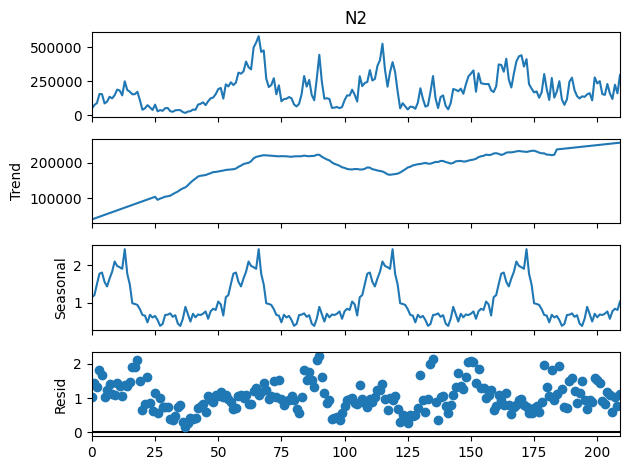

In [7]:
ANNUAL_PERIOD = 53
mult_decomp = seasonal_decompose(df_week_2020_23['N2'], model='multiplicative', extrapolate_trend='freq', period=ANNUAL_PERIOD)
mult_decomp.plot()
plt.show()

In [5]:
d = {'Jan': 20.31, 'Feb': 22.55, 'Mar': 26.3, 'Apr': 28.42, 'May': 29.17, 'Jun': 29.07,
     'Jul': 28.52, 'Aug': 28.07, 'Sep': 27.79, 'Oct': 26.79, 'Nov': 23.47, 'Dec': 20.72}

In [8]:
def create_time_series_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    From DataTime column of the original DF create features for TIme Series

    Args:
        df (pd.DataFrame): Input DataFrame with a DatetimeIndex.

    Returns:
        pd.DataFrame: DataFrame with additional time series features.

    Raises:
        ValueError: If input DataFrame does not have a DatetimeIndex.
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Input DataFrame must have a DatetimeIndex.")

    df = df.copy()

    features = {
        'hour': df.index.hour,
        'dayofweek': df.index.dayofweek,
        'quarter': df.index.quarter,
        'month': df.index.month,
        'year': df.index.year,
        'dayofyear': df.index.dayofyear,
        'dayofmonth': df.index.day,
        'weekofyear': df.index.isocalendar().week
    }
    # df.index.hour: The .hour attribute is used to access the hour component of each datetime in the DatetimeIndex. This returns a new Int64Index object containing the hours.

    for feature_name, feature_values in features.items():
        df[feature_name] = feature_values

    return df


In [30]:
e1_df = df_week_2020_23[['Date','N2']]

# e1_df = e1_df.set_index('Date')
# e1_df.index = pd.to_datetime(e1_df.index,format='%d-%m-%Y')

In [31]:
e1_df

,Date,N2
0,2020-01-12,48682.29
1,2020-01-19,75084.86
2,2020-01-26,90128.99
3,2020-02-02,156190.36
4,2020-02-09,154508.37
...,...,...
205,2023-12-03,159852.63
206,2023-12-10,119345.26
207,2023-12-17,223724.46
208,2023-12-24,160806.39


In [12]:
temp_delhi

,Day,Year,Month,Date,tavg
0,1,2020,1,2020-01-01,10.8
1,2,2020,1,2020-01-02,13.7
2,3,2020,1,2020-01-03,14.4
3,4,2020,1,2020-01-04,13.6
4,5,2020,1,2020-01-05,14.2
...,...,...,...,...,...
1454,27,2023,12,2023-12-27,49.5
1455,28,2023,12,2023-12-28,47.9
1456,29,2023,12,2023-12-29,50.6
1457,30,2023,12,2023-12-30,56.5


In [32]:
def fun(date):
    v = temp_delhi[temp_delhi.Date == date].tavg.values
    return v[0] if v else 0
e1_df['temperature'] = e1_df.Date.apply(fun)

In [48]:
temp_2020_23[temp_2020_23.Date >= '2023-01-01']['Kolkata'] = temp_2020_23[temp_2020_23.Date >= '2023-01-01']['Kolkata'] +1

In [34]:
e1_df = e1_df.set_index('Date')

In [50]:
e1_df['Temperature'] = temp_2020_23[temp_2020_23.Date > '2020-12-31']['Kolkata'].values

In [35]:
e1_df

,N2,temperature
Date,,
2020-01-12,48682.29,13.6
2020-01-19,75084.86,11.0
2020-01-26,90128.99,14.7
2020-02-02,156190.36,12.1
2020-02-09,154508.37,13.9
...,...,...
2023-12-03,159852.63,63.9
2023-12-10,119345.26,62.8
2023-12-17,223724.46,60.5


In [36]:
e1_df = create_time_series_features(e1_df)

In [37]:
e1_df.drop('hour', axis=1, inplace=True)

In [65]:
def train_xgb_regressor(X_train, y_train, X_test, y_test, use_gpu=False):
    """
    Train an XGBoost Regressor model using the provided training and test data.

    Args:
        X_train: Training feature set.
        y_train: Training target set.
        X_test: Test feature set.
        y_test: Test target set.
        use_gpu (bool): Whether to use GPU for training. Default is False.

    Returns:
        xgb.XGBRegressor: Trained XGBoost Regressor model.
    """
    additional_params = {}
    if use_gpu:
        additional_params = {'tree_method': 'gpu_hist', 'gpu_id': 0}

    xgb_regressor = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=3000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=6,
                           learning_rate=0.05,
                           min_child_weight=1,
                           subsample=0.8,
                           colsample_bytree=0.8,
                           gamma=0,
                           reg_alpha=0,
                           reg_lambda=1,
                           **additional_params)
    xgb_regressor.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


    return xgb_regressor

## Detrend E1

In [14]:
rolling_mean = e1_df.E1.rolling(window=30, center=True).mean()
detrended = e1_df['E1'] - rolling_mean

In [ ]:
plt.plot(detrended)
e1_df['Detrended'] = detrended

In [ ]:
e1_df.Detrended.fillna(1.0, inplace=True)

e1_df.tail(50)

In [59]:
features = ['dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear', 'temperature']
label = 'N2'
test_df = e1_df[e1_df.index >= '2023-05-01']
train_df = e1_df[e1_df.index < '2023-05-01']
X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]

for df in [X_train, y_train, X_test, y_test]:
    display(df.head())

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,temperature
Date,,,,,,,,
2020-01-12,6,1,1,2020,12,12,2,13.6
2020-01-19,6,1,1,2020,19,19,3,11.0
2020-01-26,6,1,1,2020,26,26,4,14.7
2020-02-02,6,1,2,2020,33,2,5,12.1
2020-02-09,6,1,2,2020,40,9,6,13.9


Date
2020-01-12     48682.29
2020-01-19     75084.86
2020-01-26     90128.99
2020-02-02    156190.36
2020-02-09    154508.37
Name: N2, dtype: float64

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,temperature
Date,,,,,,,,
2023-05-07,6,2,5,2023,127,7,18,83.1
2023-05-14,6,2,5,2023,134,14,19,92.3
2023-05-21,6,2,5,2023,141,21,20,90.5
2023-05-28,6,2,5,2023,148,28,21,84.3
2023-06-04,6,2,6,2023,155,4,22,84.3


Date
2023-05-07    167219.66
2023-05-14    175234.98
2023-05-21    128586.96
2023-05-28    168317.65
2023-06-04    301830.26
Name: N2, dtype: float64

In [66]:
model = train_xgb_regressor(X_train, y_train, X_test, y_test, use_gpu=True)

[0]	validation_0-rmse:211560.17420	validation_1-rmse:183459.78879


[100]	validation_0-rmse:21045.89110	validation_1-rmse:93139.60694
[111]	validation_0-rmse:19026.08777	validation_1-rmse:93312.64540


In [67]:
e1_df.drop([ 'prediction'], axis=1, inplace=True)
e1_df
# 'prediction_x', 'prediction_y'

,N2,temperature,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,
2020-01-12,48682.29,13.6,6,1,1,2020,12,12,2
2020-01-19,75084.86,11.0,6,1,1,2020,19,19,3
2020-01-26,90128.99,14.7,6,1,1,2020,26,26,4
2020-02-02,156190.36,12.1,6,1,2,2020,33,2,5
2020-02-09,154508.37,13.9,6,1,2,2020,40,9,6
...,...,...,...,...,...,...,...,...,...
2023-12-03,159852.63,63.9,6,4,12,2023,337,3,48
2023-12-10,119345.26,62.8,6,4,12,2023,344,10,49
2023-12-17,223724.46,60.5,6,4,12,2023,351,17,50


In [74]:
test_df['prediction'] = model.predict(X_test)

e1_df = e1_df.merge(test_df[['prediction']], how='left', left_index=True, right_index=True)

e1_df.tail(2)

,N2,temperature,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction_x,prediction_y
Date,,,,,,,,,,,
2023-12-24,160806.39,53.4,6,4,12,2023,358,24,51,220333.703125,220333.703125
2023-12-31,295964.79,59.4,6,4,12,2023,365,31,52,194229.671875,194229.671875


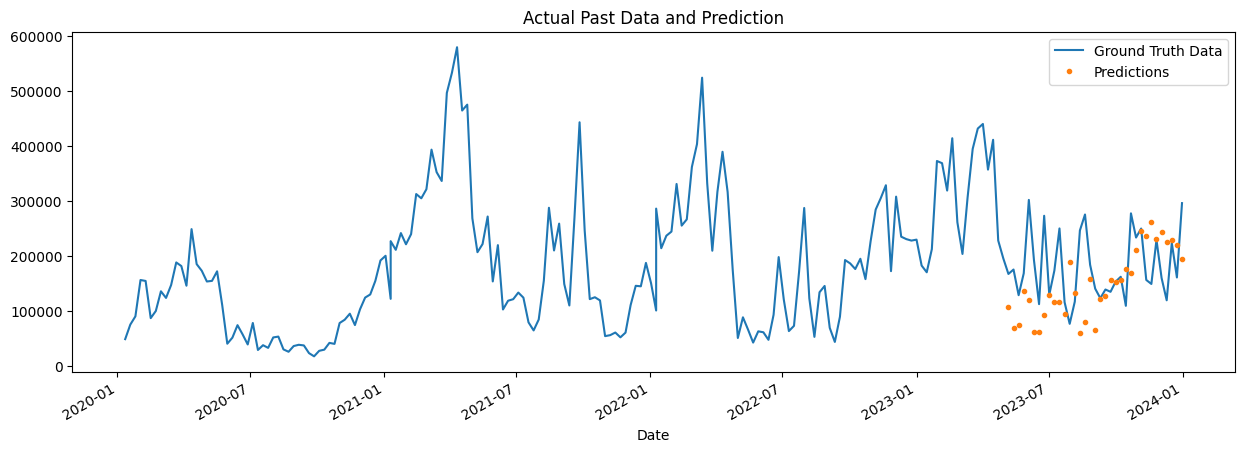

In [76]:
ax = e1_df[['N2']].plot(figsize=(15, 5))

e1_df['prediction_y'].plot(ax=ax, style='.')
plt.legend(['Ground Truth Data', 'Predictions'])
ax.set_title('Actual Past Data and Prediction')
plt.show()

In [46]:
def plot_feature_importance(model):
    """
    Plot the feature importance of a trained XGBoost model.

    Args:
        model (xgb.XGBRegressor): Trained XGBoost Regressor model.

    Returns:
        None
    """
    feat_importances = pd.DataFrame(data=model.feature_importances_,
                      index=model.feature_names_in_,
                      columns=['importance'])
    feat_importances.sort_values('importance').plot(kind='barh', title='Feature Importance')
    plt.show()

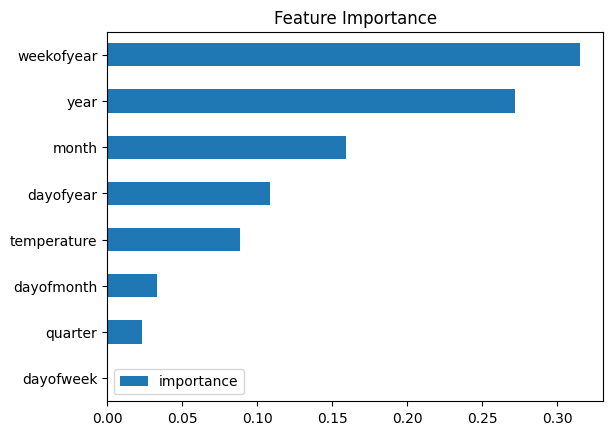

In [77]:
plot_feature_importance(model)


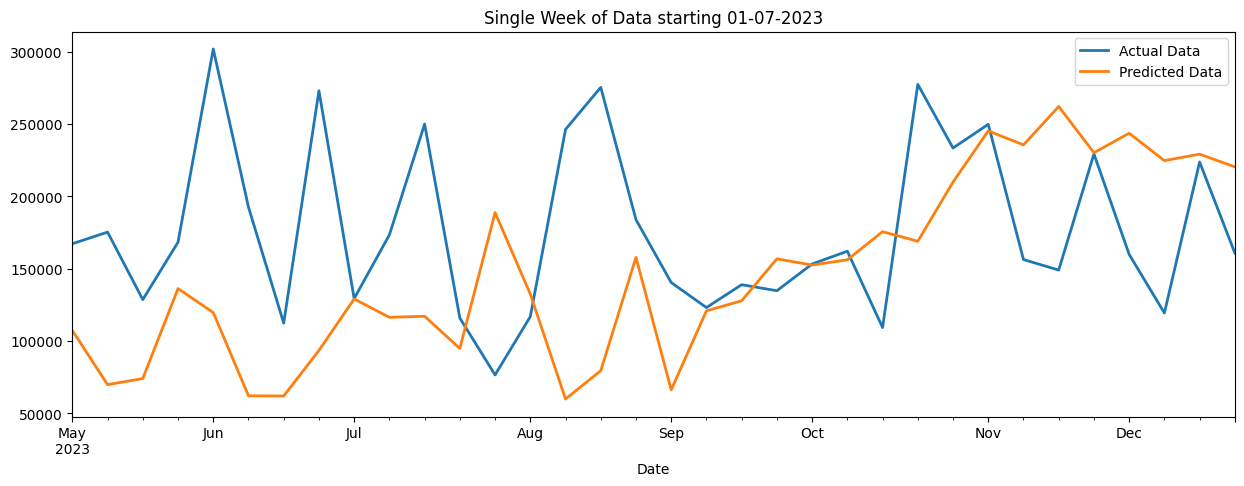

In [78]:
# select data within a specific date range
data = e1_df.loc[(e1_df.index > '2023-05-01') & (e1_df.index < '2023-12-31')]

# plot the actual and predicted data
ax = data['N2'].plot(figsize=(15, 5), title='Single Week of Data starting 01-07-2023', linewidth=2, markersize=5)

data['prediction_y'].plot(style='-', linewidth=2, markersize=5
)

plt.legend(['Actual Data', 'Predicted Data'])
plt.show()

## RSME

In [82]:
score = np.sqrt(mean_squared_error(test_df['N2'], test_df['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 90341.02


## Collecting Temperature
West Bengal - Kolkata - Done, Sikkim - Namchi, Bihar - Puna, Jharkhand - Ranchi